In [74]:
from datetime import datetime
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {
    "axes.titlesize": "x-large",
    "legend.fontsize": "x-large",
    "axes.labelsize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
}
pylab.rcParams.update(params)

from CurveInterpolator import GeneralCurveInterpolator
from CurveDataFetcher import CurveDataFetcher
from models.calibrate import (
    calibrate_ns_ols,
    calibrate_nss_ols,
    calibrate_mles_ols,
)
from utils.viz import plot_usts, run_basic_linear_regression_df, plot_residuals_timeseries

import os
from dotenv import dotenv_values
env_path = os.path.join(os.getcwd(), ".env")
config = dotenv_values(env_path)

import seaborn as sns
sns.set(style="whitegrid", palette="dark")

import nest_asyncio
nest_asyncio.apply()

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
curve_data_fetcher = CurveDataFetcher(use_ust_issue_date=True, fred_api_key=config["FRED_API_KEY"]) 

In [7]:
quote_type = "bid"
as_of_date = datetime(2024, 10, 1)

curve_set_df = curve_data_fetcher.build_curve_set(
    as_of_date=as_of_date,
    sorted=True,
    include_off_the_run_number=True,
    market_cols_to_return=[f"{quote_type}_price", f"{quote_type}_yield"],
    calc_free_float=True,
    use_github=True,
)

curve_set_df

,cusip,security_type,auction_date,issue_date,maturity_date,time_to_maturity,int_rate,high_investment_rate,is_on_the_run,ust_label,...,parValue,percentOutstanding,est_outstanding_amt,corpus_cusip,outstanding_amt,portion_unstripped_amt,portion_stripped_amt,reconstituted_amt,free_float,rank
0,912797LK1,Bill,2024-08-29,2024-09-03,2024-10-01,0.000000,NaN,5.263,False,5.263% Oct-24,...,7.639260e+08,0.003311,2.307445e+11,NaN,0.000000e+00,NaN,0.000000e+00,NaN,-763.9260,17.0
1,912797LS4,Bill,2024-09-05,2024-09-10,2024-10-08,0.019178,NaN,5.171,False,5.171% Oct-24,...,7.725101e+08,0.003348,2.307550e+11,NaN,0.000000e+00,NaN,0.000000e+00,NaN,-772.5101,16.0
2,912797LT2,Bill,2024-09-12,2024-09-17,2024-10-15,0.038356,NaN,5.053,False,5.053% Oct-24,...,7.980483e+08,0.003458,2.307652e+11,NaN,0.000000e+00,NaN,0.000000e+00,NaN,-798.0483,15.0
3,912797LU9,Bill,2024-09-19,2024-09-24,2024-10-22,0.057534,NaN,4.783,False,4.783% Oct-24,...,7.665970e+08,0.003322,2.307539e+11,NaN,0.000000e+00,NaN,0.000000e+00,NaN,-766.5970,14.0
4,912797LV7,Bill,2024-09-26,2024-10-01,2024-10-29,0.076712,NaN,4.783,True,4.783% Oct-24,...,4.031029e+08,0.002871,1.404022e+11,NaN,0.000000e+00,NaN,0.000000e+00,NaN,-403.1029,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,912810TT5,Bond,2023-10-12,2023-10-16,2053-08-15,28.890411,4.125,NaN,False,4.125% Aug-53,...,8.606596e+09,0.120247,7.157430e+10,912803GU1,7.157430e+10,60954881.0,1.061942e+10,991450.0,52348.2848,4.0
390,912810TV0,Bond,2024-01-11,2024-01-16,2053-11-15,29.142466,4.750,NaN,False,4.75% Nov-53,...,4.567153e+08,0.006874,6.644364e+10,912803GW7,6.644364e+10,56812091.9,9.631553e+09,1679110.0,56355.3766,3.0
391,912810TX6,Bond,2024-04-11,2024-04-15,2054-02-15,29.394521,4.250,NaN,False,4.25% Feb-54,...,2.211754e+09,0.031064,7.119879e+10,912803GY3,7.119879e+10,58204025.7,1.299477e+10,792000.0,55992.2712,2.0
392,912810UA4,Bond,2024-07-11,2024-07-15,2054-05-15,29.638356,4.625,NaN,False,4.625% May-54,...,7.428279e+09,0.097202,7.642080e+10,912803HB2,7.642080e+10,68393441.8,8.027362e+09,1220467.0,60965.1628,1.0


In [8]:
otr_df = curve_set_df[curve_set_df["is_on_the_run"]].sort_values(by=["time_to_maturity"])
otr_fit_interpolator = GeneralCurveInterpolator(
    x=otr_df["time_to_maturity"].to_numpy(),
    y=otr_df[f"{quote_type}_yield"].to_numpy(),
)

In [89]:
# remove otr, olds, double olds, triple olds
curve_set_filtered_df = curve_set_df[
    (curve_set_df["rank"] != 0)
    & (curve_set_df["rank"] != 1)
    & (curve_set_df["rank"] != 2)
    & (curve_set_df["rank"] != 3)
]

# remove TBills
curve_set_filtered_df = curve_set_filtered_df[
    curve_set_filtered_df["security_type"] != "Bill"
]

# remove low free float bonds (< $5bn)
curve_set_filtered_df = curve_set_filtered_df[
    curve_set_filtered_df["free_float"] > 5000
]

# filter out bonds very close to maturity
curve_set_filtered_df = curve_set_filtered_df[
    curve_set_filtered_df["time_to_maturity"] > 30 / 360
]

# remove CTDs
curve_set_filtered_df = curve_set_filtered_df[
    ~curve_set_filtered_df["cusip"].isin(
        [
            curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.625s 2026-09-15")["cusip"], # TU
            curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.125s 2027-09-30")["cusip"], # Z3N
            curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.25s 2029-02-28")["cusip"], # FV
            curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.25s 2031-06-30")["cusip"], # TY
            curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.375s 2034-05-15")["cusip"], # TN
            curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.625s 2040-02-15")["cusip"], # US
            curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.5s 2044-02-15")["cusip"], # TWE
            curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.75s 2053-11-15")["cusip"], # UL
        ]
    )
]

curve_set_filtered_df = curve_set_filtered_df.sort_values(by=["time_to_maturity"])

filtered_fitted_interpolator = GeneralCurveInterpolator(
    x=curve_set_filtered_df["time_to_maturity"].to_numpy(),
    y=curve_set_filtered_df[f"{quote_type}_yield"].to_numpy(),
)

In [40]:
ns_func, status_ns = calibrate_ns_ols(
    curve_set_filtered_df["time_to_maturity"].to_numpy(),
    curve_set_filtered_df[f"{quote_type}_yield"].to_numpy(),
)
assert status_ns

nss_func, status_nss, _ = calibrate_nss_ols(
    curve_set_filtered_df["time_to_maturity"].to_numpy(),
    curve_set_filtered_df[f"{quote_type}_yield"].to_numpy(),
)
assert status_nss

mles_func, status_mles = calibrate_mles_ols(
    curve_set_filtered_df["time_to_maturity"].to_numpy(),
    curve_set_filtered_df[f"{quote_type}_yield"].to_numpy(),
    overnight_rate=5.31,
    N=9,
)

In [91]:
fitted_bspline = filtered_fitted_interpolator.b_spline_with_knots_interpolation(
    knots=[0.5, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 15, 20, 25],
    k=3,
    return_func=True,
)
fitted_unispline = filtered_fitted_interpolator.univariate_spline(s=1.75, return_func=True)

plot_usts(
    curve_set_df=curve_set_df,
    ttm_col="time_to_maturity",
    ytm_col=f"{quote_type}_yield",
    hover_data=[
        "issue_date",
        "maturity_date",
        "cusip",
        "original_security_term",
        "ust_label",
        f"{quote_type}_price",
        "free_float",
    ],
    ust_labels_highlighter=[("3.125% Nov-41", "red"), ("2.000% Nov-41", "blue")],
    zero_curves=[
        # (
        #     otr_fit_interpolator.pchip_interpolation(return_func=True),
        #     "PCHIP Intrp - OTR Fit",
        # ),
        (
            fitted_bspline,
            "BSpline k=3 - Zero Filtered Fit",
        ),
        # (
        #     mles_func,
        #     "Zero, MLES"
        # ),
    ],
    par_curves=[
        (
            fitted_bspline,
            "BSpline k=3 - Par FF",
        ),
        # (
        #     fitted_unispline,
        #     "Unispline s=1.75 - Par FF",
        # ),
        # (
        #     mles_func,
        #     "Par, MLES",
        #     True
        # ),
    ],
    # n_yr_fwd_curves=[
    #     (
    #         nss_func,
    #         1,
    #         "1yr Fwd, NSS",
    #     ) 
    # ]
    impl_spot_n_yr_fwd_curves=[
        (fitted_bspline, 1, "Impl Spots, 1y Fwd"),
    ],
    impl_par_n_yr_fwd_curves=[
        (fitted_bspline, 1, "Impl Par, 1y Fwd"),
        # (
        #     mles_func,
        #     1,
        #     "1yr Fwd, MLES",
        #     True
        # )
    ],
    title=f"All USTs - using {f"{quote_type}_yield"} - as of {as_of_date}"
)

In [254]:
nov_41s_df = curve_data_fetcher.fetch_spreads(
    ust_label_spread="3.125% Nov-41 / 2.000% Nov-41",
    start_date=datetime(2024, 1, 1),
    end_date=datetime(2024, 9, 26),
)

In [10]:
def liquidity_premium_curve_set_filter(curve_set_df: pd.DataFrame):
    curve_set_filtered_df = curve_set_df[
        (curve_set_df["rank"] != 0)
        & (curve_set_df["rank"] != 1)
        & (curve_set_df["rank"] != 2)
        & (curve_set_df["rank"] != 3)
    ]

    # remove TBills
    curve_set_filtered_df = curve_set_filtered_df[
        curve_set_filtered_df["security_type"] != "Bill"
    ]

    # remove low free float bonds (< $5bn)
    curve_set_filtered_df = curve_set_filtered_df[
        curve_set_filtered_df["free_float"] > 5000
    ]

    # filter out bonds very close to maturity
    curve_set_filtered_df = curve_set_filtered_df[
        curve_set_filtered_df["time_to_maturity"] > 30 / 360
    ]

    # remove CTDs
    curve_set_filtered_df = curve_set_filtered_df[
        ~curve_set_filtered_df["cusip"].isin(
            [
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.625s 2026-09-15")["cusip"], # TU
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.125s 2027-09-30")["cusip"], # Z3N
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.25s 2029-02-28")["cusip"], # FV
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.25s 2031-06-30")["cusip"], # TY
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.375s 2034-05-15")["cusip"], # TN
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.625s 2040-02-15")["cusip"], # US
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.5s 2044-02-15")["cusip"], # TWE
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.75s 2053-11-15")["cusip"], # UL
            ]
        )
    ]

    curve_set_filtered_df = curve_set_filtered_df.sort_values(by=["time_to_maturity"])
    
    return curve_set_filtered_df

In [50]:
start_date = datetime(2024, 3, 1)
end_date = datetime(2024, 10, 1)

curve_sets_dict_df, fitted_curves_dict = curve_data_fetcher.fetch_historical_curve_sets(
    start_date=start_date,
    end_date=end_date,
    fetch_soma_holdings=True,
    fetch_stripping_data=True,
    calc_free_float=True,
    fitted_curves=[("LPF", "eod_yield", liquidity_premium_curve_set_filter)],
)

AGGREGATING CURVE SET DFs: 100%|██████████| 190/190 [00:05<00:00, 37.37it/s]


In [51]:
cusip_spreads = {}

for dt in curve_sets_dict_df.keys():
    fitted_bspline = fitted_curves_dict[dt]["LPF"].b_spline_with_knots_interpolation(
        knots=[0.5, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 15, 20, 25],
        k=3,
        return_func=True,
    )
    curr_curve_set_df = curve_sets_dict_df[dt][["cusip", "time_to_maturity", "eod_yield"]]
    curr_curve_set_df["fitted_yield"] = fitted_bspline(curr_curve_set_df["time_to_maturity"])
    curr_curve_set_df["fitted_spread"] = curr_curve_set_df["eod_yield"] - curr_curve_set_df["fitted_yield"]
    curr_curve_set_df["fitted_15s20s"] = fitted_bspline(20) - fitted_bspline(15)
    for _, row in curr_curve_set_df.iterrows():
        if row["cusip"] not in cusip_spreads:
            cusip_spreads[row["cusip"]] = []

        cusip_spreads[row["cusip"]].append(
            {
                "Date": dt,
                "eod_yield": row["eod_yield"],
                "fitted_yield": row["fitted_yield"],
                "fitted_spread": row["fitted_spread"],
                "fitted_15s20s": row["fitted_15s20s"],
            }
        )

In [79]:
label1 = "3.125% Nov-41"
cusip1 = curve_data_fetcher.ust_data_fetcher.ust_label_to_cusip(label1)["cusip"]

label2 = "2.0% Nov-41"
cusip2 = curve_data_fetcher.ust_data_fetcher.ust_label_to_cusip(label2)["cusip"]

cusip1_df = pd.DataFrame(cusip_spreads[cusip1])
cusip2_df = pd.DataFrame(cusip_spreads[cusip2])

spread_df = pd.DataFrame({
    "Date": cusip1_df["Date"],
    label1: cusip1_df["eod_yield"],
    label2: cusip2_df["eod_yield"], 
    f"{label1} / {label2}": cusip2_df["eod_yield"] - cusip1_df["eod_yield"],
    "fitted_15s20s": cusip1_df["fitted_15s20s"]
})

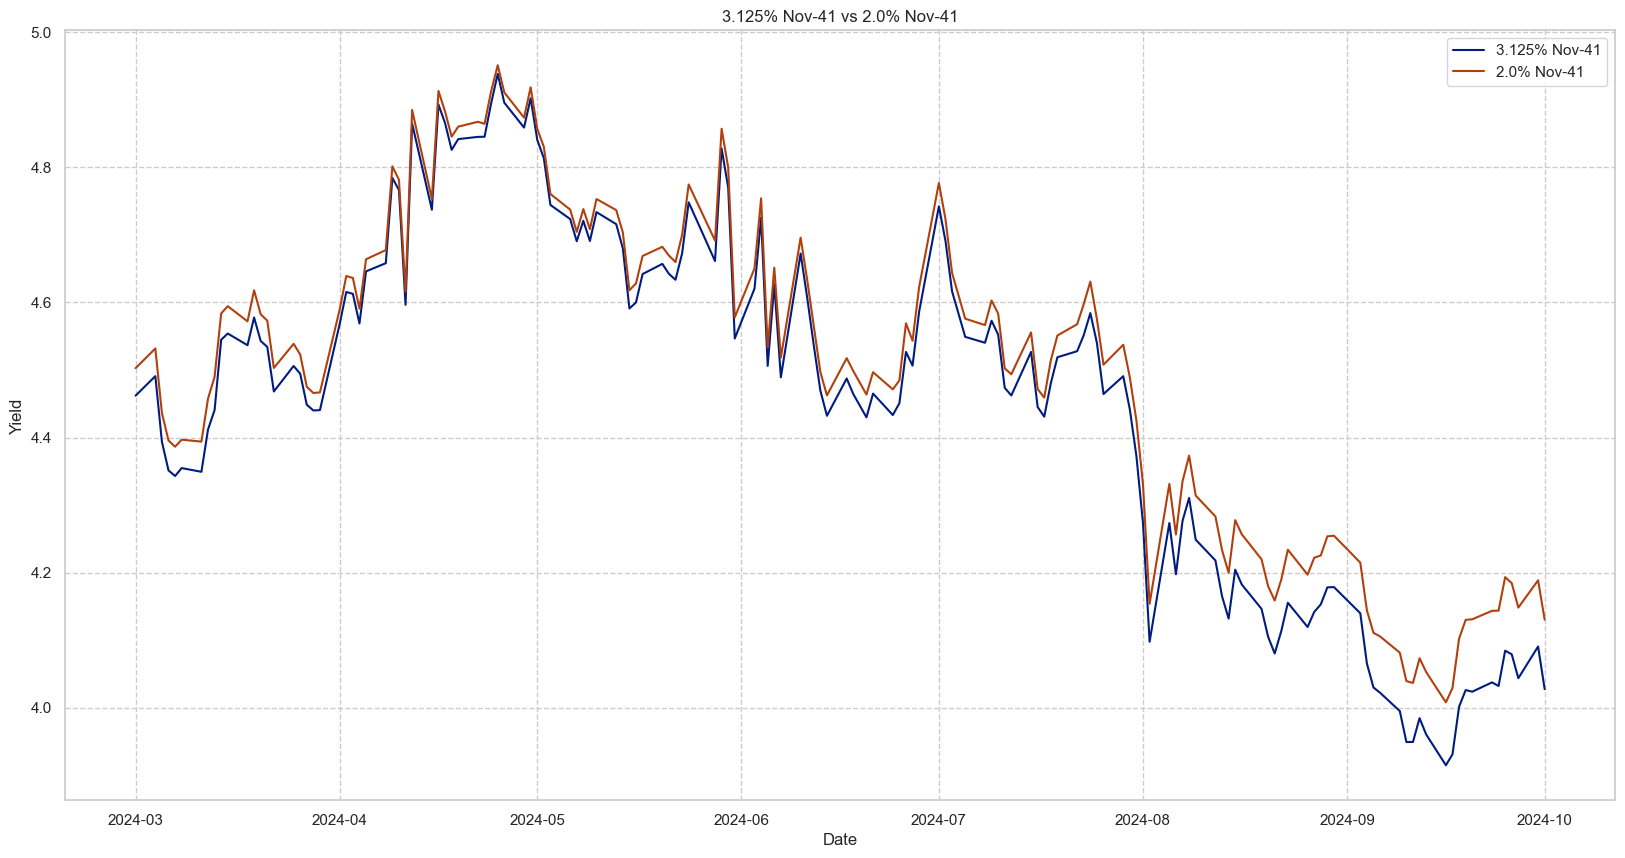

In [80]:
plt.figure(figsize=(20, 10))
plt.plot(spread_df["Date"], spread_df[label1], label=label1)
plt.plot(spread_df["Date"], spread_df[label2], label=label2)
plt.xlabel("Date")
plt.ylabel("Yield")
plt.title(f"{label1} vs {label2}")
plt.legend()
plt.grid(True)
plt.show()

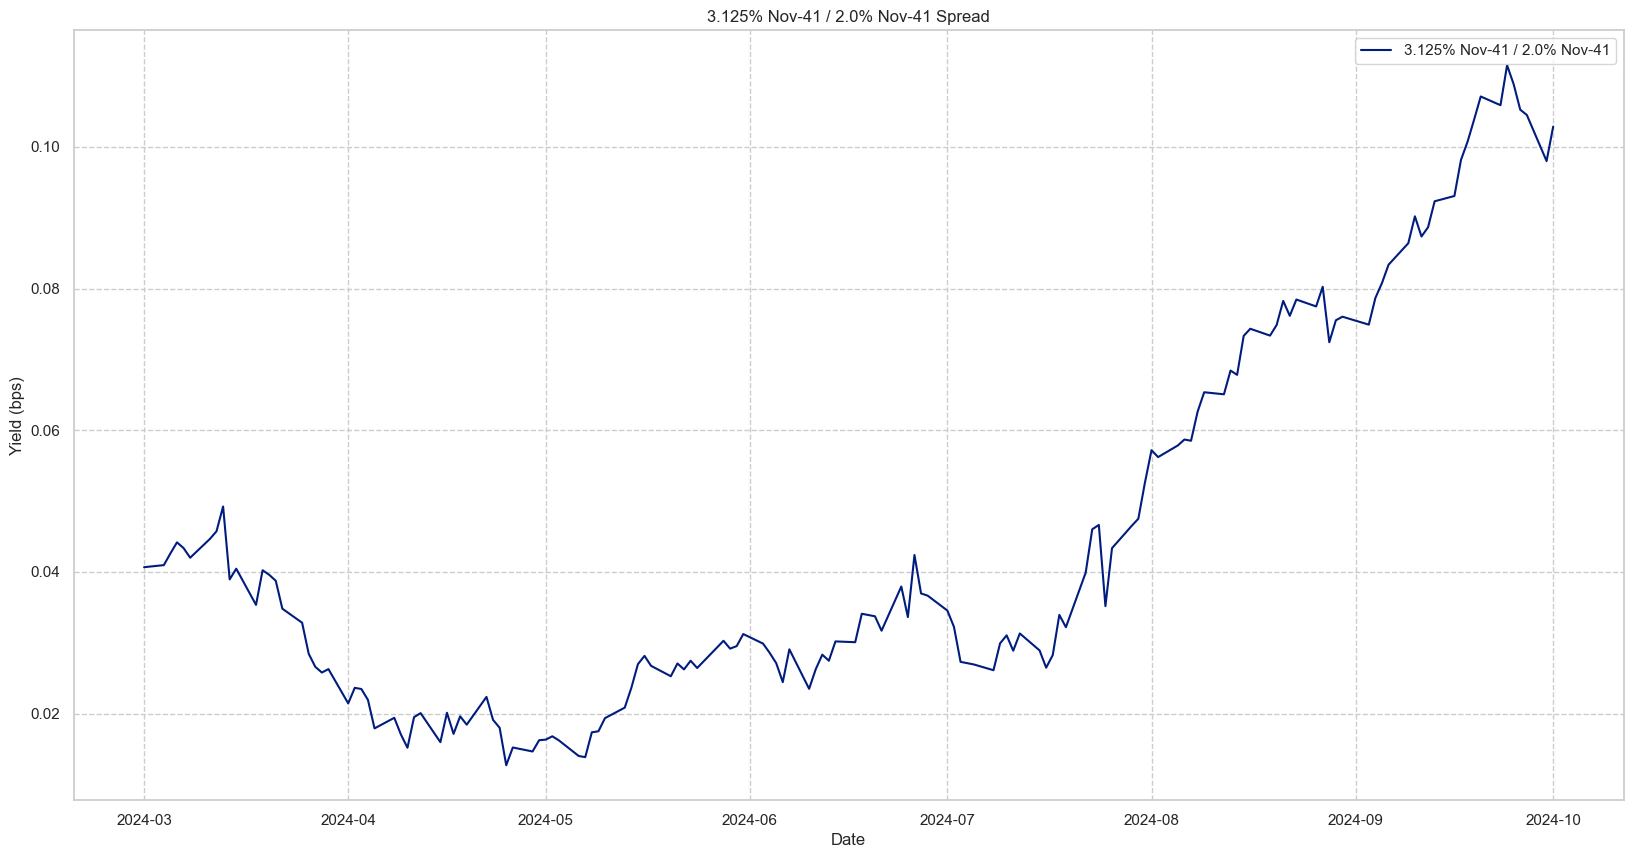

In [81]:
plt.figure(figsize=(20, 10))
plt.plot(spread_df["Date"], spread_df[f"{label1} / {label2}"], label=f"{label1} / {label2}")
plt.xlabel("Date")
plt.ylabel("Yield (bps)")
plt.title(f"{label1} / {label2} Spread")
plt.legend()
plt.grid(True)
plt.show()

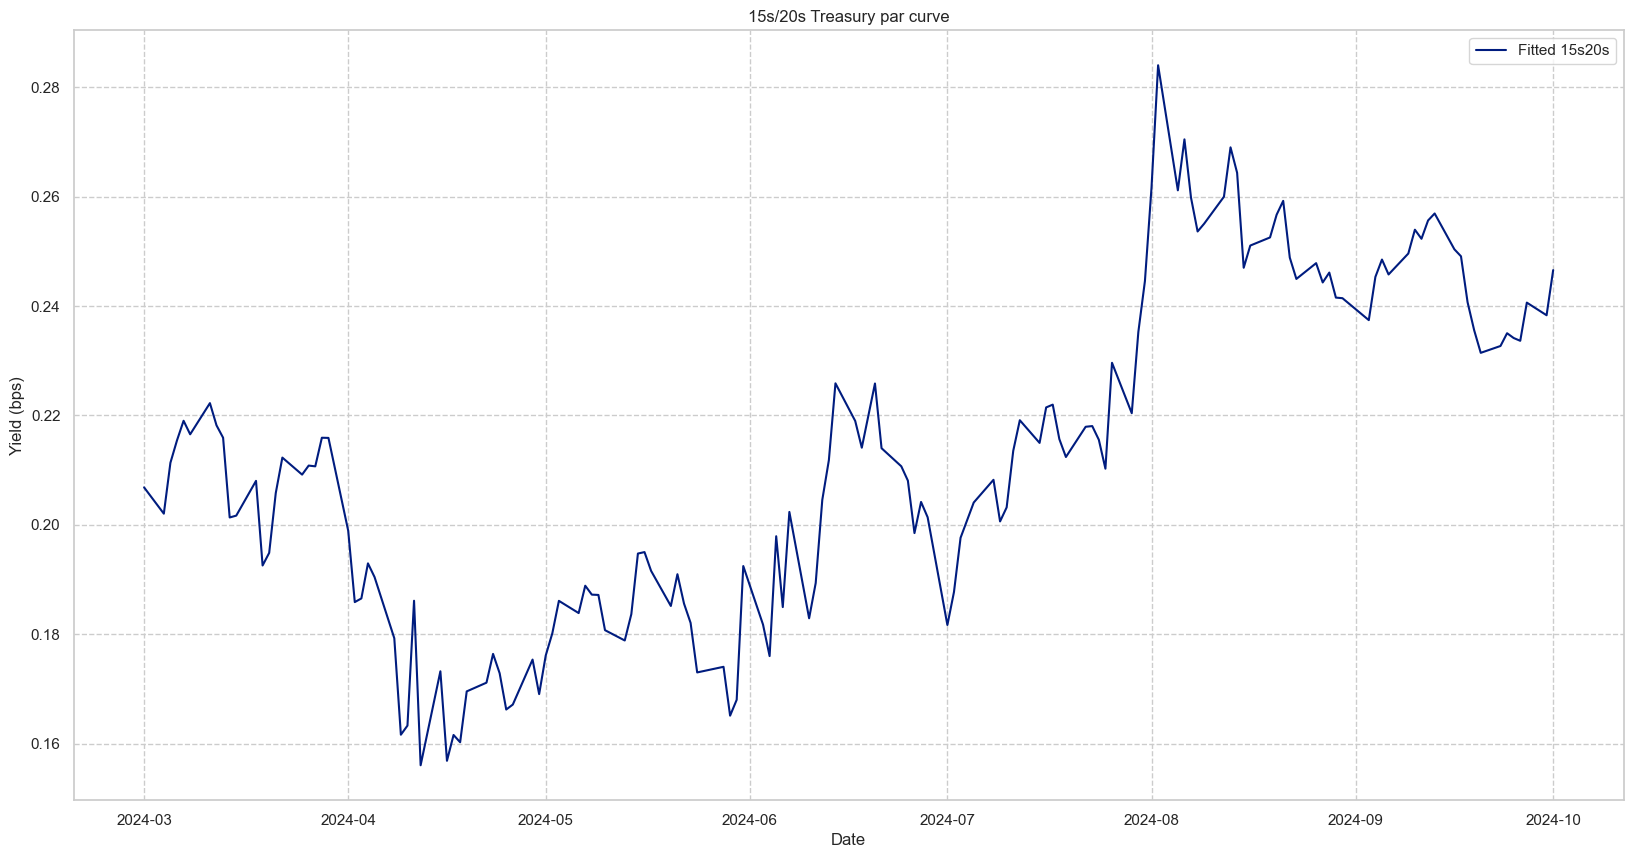

In [84]:
plt.figure(figsize=(20, 10))
plt.plot(spread_df["Date"], spread_df["fitted_15s20s"], label="Fitted 15s20s")
plt.xlabel("Date")
plt.ylabel("Yield (bps)")
plt.title("15s/20s Treasury par curve")
plt.legend()
plt.grid(True)
plt.show()

                                 OLS Regression Results                                
Dep. Variable:     3.125% Nov-41 / 2.0% Nov-41   R-squared:                       0.643
Model:                                     OLS   Adj. R-squared:                  0.641
Method:                          Least Squares   F-statistic:                     264.7
Date:                         Thu, 03 Oct 2024   Prob (F-statistic):           1.08e-34
Time:                                 15:00:32   Log-Likelihood:                 405.18
No. Observations:                          149   AIC:                            -806.4
Df Residuals:                              147   BIC:                            -800.3
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

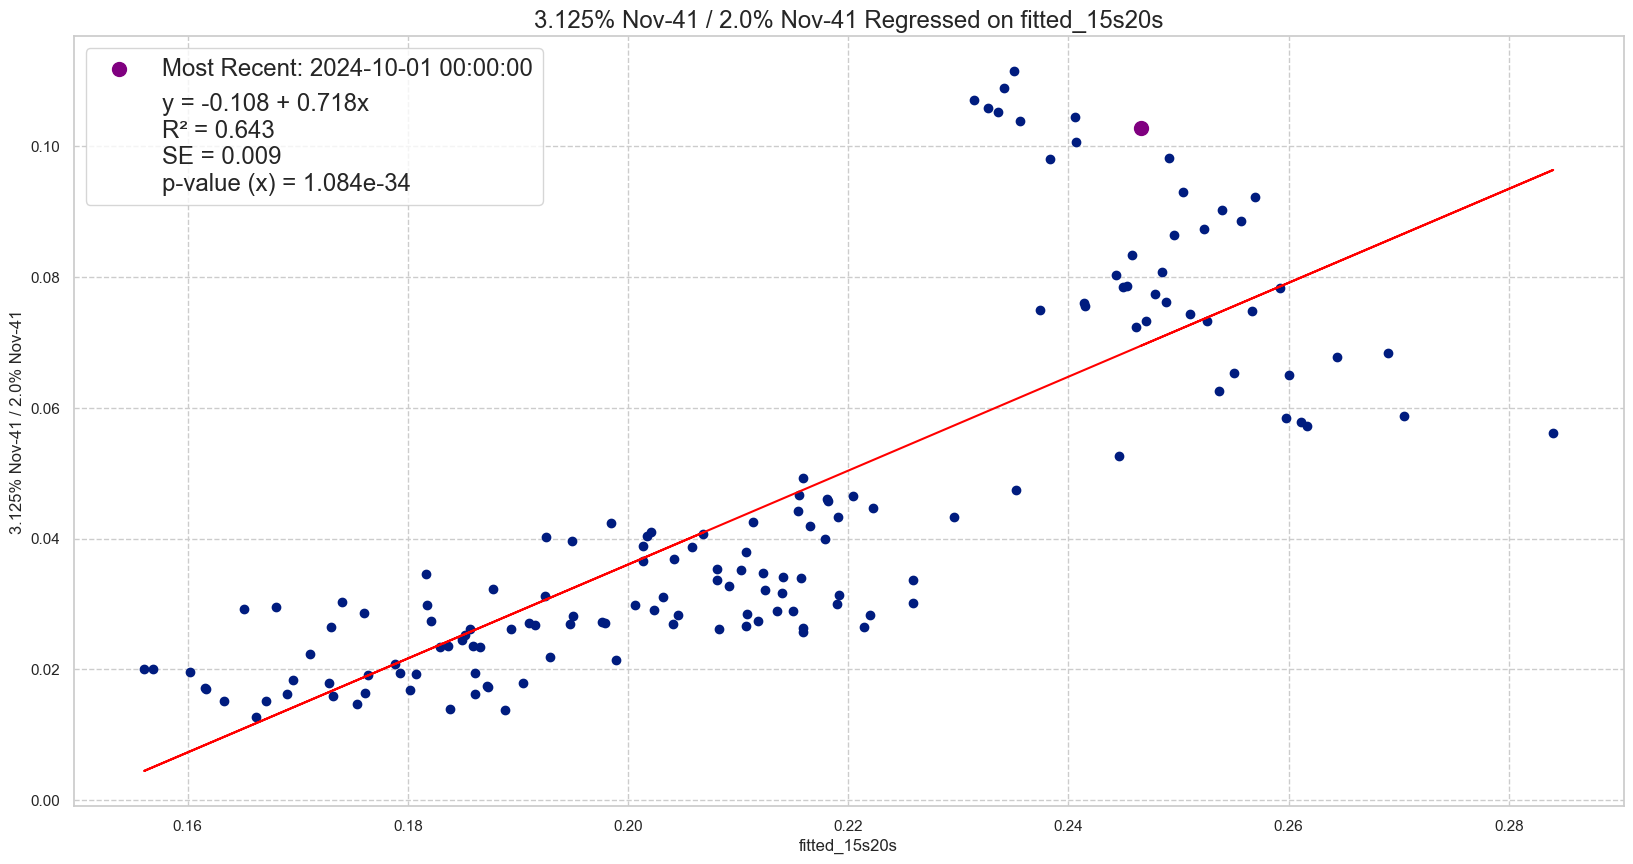

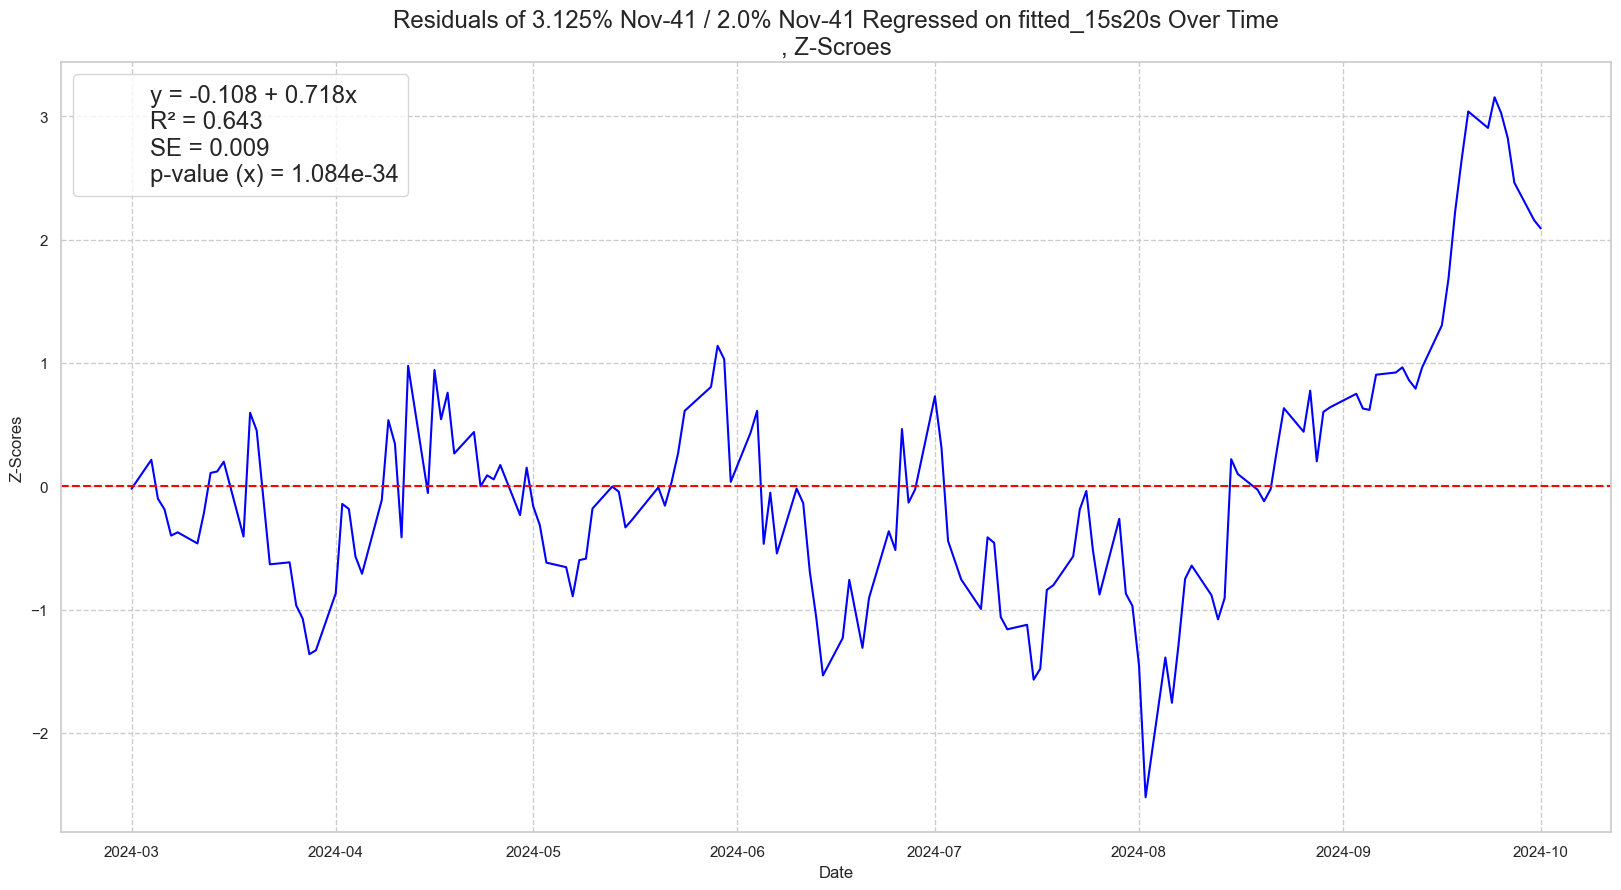

In [93]:
r = run_basic_linear_regression_df(
    df=spread_df,
    x_col="fitted_15s20s",
    y_col=f"{label1} / {label2}",
)

plot_residuals_timeseries(df=spread_df, results=r, plot_zscores=True)